Transient Heat Transfer 1D
================

Let's get the process ID so that we can attach a debug later.

In [1]:
import os
print(os.getpid())

14460


In [2]:
# NOT WORKING
#%load_ext Cython
#%%cython -f -n CavityFlow2D --lib=petsc --lib=python3 
#-LD:\\Work\\Miniconda3\\envs\\petsc_debug\\Library\\lib 
#-I=./ -ID:\\Work\\Miniconda3\\envs\\petsc_debug\\lib\\site-packages\\petsc4py\\include 
#-ID:\\Work\\Miniconda3\\envs\\petsc_debug\\Library\\include\\ 
#-ID:\\Work\\Miniconda3\\envs\\petsc_debug\\Library\\include\\petsc\\mpiuni 
#--link-args=-debug --compile-args=-Zi --compile-args=/Od
#%save CavityFlow2D.pyx

file_content='''
from petsc4py.PETSc cimport Vec,  PetscVec
from petsc4py.PETSc cimport DM,   PetscDM
from petsc4py.PETSc cimport SNES, PetscSNES
from petsc4py.PETSc cimport TS,   PetscTS

from petsc4py.PETSc import Error

cdef extern from "HeatTransfer1Dimpl.h":
    ctypedef struct Params:
        double temperature_left_
        double temperature_right_
        double conductivity_
        double source_term_
        double wall_length_
        
    int FormInitGuess(PetscDM da, PetscVec x, Params *p)
    int FormFunction (PetscTS ts, double t, PetscVec X, PetscVec X_t, PetscVec F, Params *p)

def formInitGuess(Vec x, DM da, double temperature_left_, 
    double temperature_right_, double conductivity_, 
    double source_term_, double wall_length_):
    cdef int ierr
    cdef Params p = {
        "temperature_left_" : temperature_left_, 
        "temperature_right_" : temperature_right_, 
        "conductivity_" : conductivity_,
        "source_term_" : source_term_,
        "wall_length_" : wall_length_,
    }
    ierr = FormInitGuess(da.dm, x.vec, &p)
    if ierr != 0: raise Error(ierr)

def formFunction(TS ts, double t, Vec x, Vec x_t, Vec f, double temperature_left_, 
    double temperature_right_, double conductivity_, 
    double source_term_, double wall_length_):
    cdef int ierr
    cdef Params p = {
        "temperature_left_" : temperature_left_, 
        "temperature_right_" : temperature_right_, 
        "conductivity_" : conductivity_,
        "source_term_" : source_term_,
        "wall_length_" : wall_length_,
    }
    ierr = FormFunction(ts.ts, t, x.vec, x_t.vec, f.vec, &p)
    if ierr != 0: raise Error(ierr)
'''

text_file = open("HeatTransfer1D.pyx", "w")

text_file.write(file_content)

text_file.close()

In [3]:
# First you need to call
!python setup.py build_ext --inplace

inside config
['D:\\Work\\Miniconda3\\envs\\petsc_debug\\Library\\include', 'D:\\Work\\Miniconda3\\envs\\petsc_debug\\Library\\include\\petsc\\mpiuni', 'D:\\Work\\Miniconda3\\envs\\petsc_debug\\lib\\site-packages\\petsc4py\\include']
running build_ext
running build_src
build_src
building extension "HeatTransfer1D" sources
cythonc:> .\HeatTransfer1D.c
build_src: building npy-pkg config files
No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
customize MSVCCompiler
customize MSVCCompiler using build_ext
building 'HeatTransfer1D' extension
compiling C sources
C:\Program Files (x86)\Microsoft Visual Studio 14.0\VC\BIN\x86_amd64\cl.exe /c /nologo /Ox /W3 /GL /DNDEBUG /MD -ID:\Work\Miniconda3\envs\petsc_debug\Library\include -ID:\Work\Miniconda3\envs\petsc_debug\Library\include\petsc\mpiuni -ID:\Work\Miniconda3\envs\petsc_debug\lib\site-packages\petsc4py\include -I. -ID:\Work\Miniconda3\envs\petsc_debug\lib\site-packages\numpy\core\include -ID:\Work\Min

In [4]:
import argparse
import sys
import petsc4py
import numpy as np
from numpy import mgrid
petsc4py.init(sys.argv)
from petsc4py import PETSc
from matplotlib import pyplot as plt
import HeatTransfer1D

nx = 1000
dt = 0.001
time_intervals = [0.001, 0.01, 0.05, 0.1, 1.0]
temperature_left  = 0.0
temperature_right = 50.0
conductivity = 1.0
source_term = 0.0
wall_length = 1.0
    
def transient_heat_transfer_1D(
    nx, temperature_left, 
    temperature_right, 
    conductivity,
    source_term,
    wall_length,
    final_time,
    initial_time_step
    ):
    ts = PETSc.TS().create()

    da = PETSc.DMDA().create([nx],dof=1, stencil_width=1, stencil_type='star')
    ts.setDM(da)

    F = da.createGlobalVec()
    ts.setIFunction(HeatTransfer1D.formFunction, F,
                     args=(temperature_left, temperature_right, conductivity, source_term, wall_length))

    x = da.createGlobalVec()
    HeatTransfer1D.formInitGuess(x, da, temperature_left, temperature_right, conductivity, source_term, wall_length)

    ts.setDuration(max_time=final_time, max_steps=None)
    ts.setExactFinalTime(ts.ExactFinalTimeOption.STEPOVER)
    
    ts.setInitialTimeStep(initial_time=0.0, initial_time_step=initial_time_step)
    
    #ts.setType(ts.Type.CRANK_NICOLSON)
    ts.setFromOptions()

    ts.solve(x)
    #print(final_time, x[...])
    
    #ftime = ts.getSolveTime()
    #print(ts.getConvergedReason())
    return x

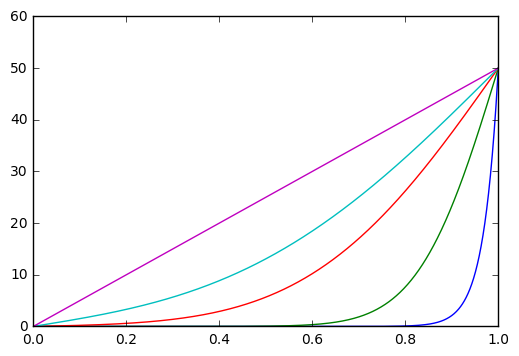

In [5]:
sols = []
for final_time in time_intervals:
    sol = transient_heat_transfer_1D(
        nx, temperature_left, 
        temperature_right, 
        conductivity,
        source_term,
        wall_length,
        final_time,
        dt
        )
    sols.append(sol[...])
    
x = np.linspace(0, wall_length, nx)
for sol in sols:
    plt.plot(x, sol)
plt.show()